# Pipeline for analyzing flow cytometry data

In [1]:
from FlowCytometryTools import *
import numpy as np
import pandas as pd
import math
import matplotlib
import matplotlib.pyplot as plt
import glob
import seaborn as sns

import os
import sys

path = '/Users/andrewng/Documents/AHN_FlowTools/'
if not path in sys.path:
    sys.path.insert(1, path)
del path

from AHN_FlowTools import *

sns.set_style('white')
sns.set_style('ticks')
%matplotlib inline

In [2]:
datadir = list()

datadir.append('/Users/andrewng/Documents/HES Lab/Flow Cytometry/ahn20180820_MATfbtune/Plate1/')
datadir.append('/Users/andrewng/Documents/HES Lab/Flow Cytometry/ahn20180820_MATfbtune/Plate2/')
datadir.append('/Users/andrewng/Documents/HES Lab/Flow Cytometry/ahn20180820_MATfbtune/Plate3/')

date = '20180820'

allfiles = {}
strains = ['Plate1','Plate2','Plate3']

for i in range(len(datadir)):
    files = glob.glob(datadir[i] + '*.fcs')
    allfiles[strains[i]] = files

In [3]:
rows = ['A','B','C','D','E','F','G','H']
cols = ['01','02','03','04','05','06','07','08','09','10','11','12']

In [4]:
plateraw = pd.DataFrame(index = rows, columns = cols)

panelDict = {strain:plateraw for strain in strains}
allplates = pd.Panel(panelDict)

/Users/andrewng/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2878: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
for strain in strains:
    for f in allfiles[strain]:
        c = f[-10:-8]
        r = f[-11]
        call = r + c
        allplates[strain].set_value(r, c, FCMeasurement(ID = call, datafile = f))

/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


In [6]:
def FCdatastats(platesort,normalized=None,rows=None,cols=None,FITCthresh=None,FSCthresh=None):

    #Calculate the linear median, mean, and SD for each of the wells. Create two different Panels, one for FITC and one
    #for mCherry. In each Panel store a DataFrame containing the median, mean, SD, and CV

    if normalized is None:
        normalized = True
    if rows is None:
        rows = ['A','B','C','D','E','F','G','H']
    if cols is None:
        cols = ['01','02','03','04','05','06','07','08','09','10','11','12']
    if FITCthresh is None:
        FITCthresh = 100
    if FSCthresh is None:
        FSCthresh = 1000

    empty = pd.DataFrame(index = rows, columns = cols)

    FITCstats = pd.Panel({'raw':empty, 'med':empty, 'avg':empty, 'sd':empty, 'cv':empty})
    RFPstats = pd.Panel({'raw':empty, 'med':empty, 'avg':empty, 'sd':empty,'cv':empty})
    BFPstats = pd.Panel({'raw':empty, 'med':empty, 'avg':empty, 'sd':empty,'cv':empty})

    for row in rows:
        for col in cols:

            try:
                FCM = gate(platesort.loc[row,col],'FITC-H',FITCthresh)

                FCM2 = FCM[FCM['SSC-H'] > FSCthresh]
            except TypeError:
                continue

            try:
                if normalized == True:
                    FITC = FCM2['FITC-H']/FCM2['SSC-H']
                    RFP = FCM2['PE-Texas Red-H']/FCM2['SSC-H']
                    BFP = FCM2['DAPI-H']/FCM2['SSC-H']

                elif normalized == False:
                    FITC = FCM2['FITC-H']
                    RFP = FCM2['PE-Texas Red-H']
                    BFP = FCM2['DAPI-H']

                FITCstats.raw.set_value(row, col, FITC)
                FITCstats.med.set_value(row,col,FITC.median(axis=0))
                FITCstats.avg.set_value(row,col,FITC.mean(axis=0))
                FITCstats.sd.set_value(row,col,FITC.std(axis=0))
                FITCstats.cv.set_value(row,col,FITCstats.avg.loc[row,col]/FITCstats.sd.loc[row,col])

                RFPstats.raw.set_value(row, col, RFP)
                RFPstats.med.set_value(row,col,RFP.median(axis=0))
                RFPstats.avg.set_value(row,col,RFP.mean(axis=0))
                RFPstats.sd.set_value(row,col,RFP.std(axis=0))
                RFPstats.cv.set_value(row,col,RFPstats.avg.loc[row,col]/RFPstats.sd.loc[row,col])

                BFPstats.raw.set_value(row, col, BFP)
                BFPstats.med.set_value(row,col,BFP.median(axis=0))
                BFPstats.avg.set_value(row,col,BFP.mean(axis=0))
                BFPstats.sd.set_value(row,col,BFP.std(axis=0))
                BFPstats.cv.set_value(row,col,BFPstats.avg.loc[row,col]/BFPstats.sd.loc[row,col])
                
            except (AttributeError, TypeError):
                continue

    return [FITCstats, RFPstats, BFPstats]


In [7]:
FITCnorm = {}
RFPnorm = {}
BFPnorm = {}

for strain in strains: 
    [FITCnorm[strain], RFPnorm[strain],BFPnorm[strain]] = FCdatastats(allplates[strain],1,rows,cols,10,1000)


/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  
/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:44: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:45: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:46: FutureWarning: set_value is deprecated and will be remov

In [8]:
#Define the rows

Aconcind = range(12)

Aconc = list()

for j in range(11):
    Aconc.append(round(100*0.5**j,2))

Ax = [round(100*0.5**i,2) for i in range(11)]

Aconc.append(0)

Ax.append(0)

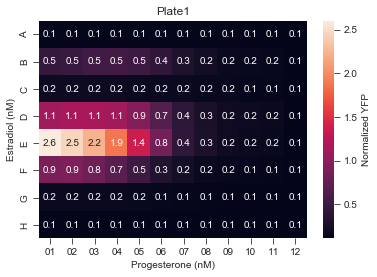

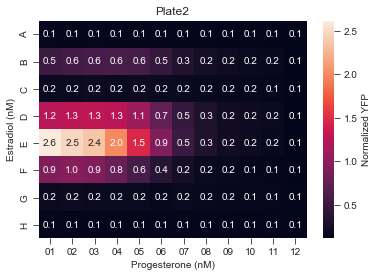

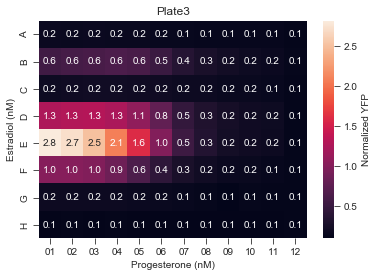

In [10]:
for plate in strains:
    sns.heatmap(FITCnorm[plate].med.astype(float),annot=True,fmt='.1f',cbar_kws={'label': 'Normalized YFP'})
    plt.title(plate)
    plt.xlabel('Progesterone (nM)')
    plt.ylabel('Estradiol (nM)')

    dest = date + plate + 'YFPheatmap'
    plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
    plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)
    plt.show()
    plt.close()

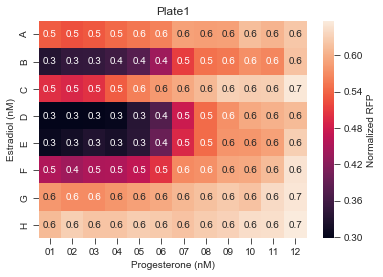

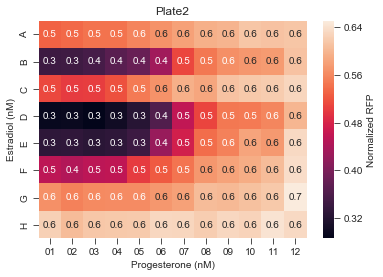

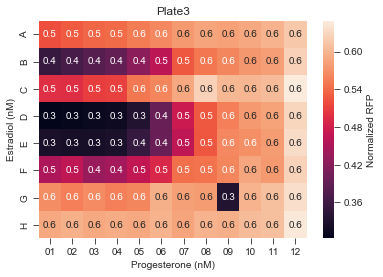

In [11]:
for plate in strains:
    sns.heatmap(RFPnorm[plate].med.astype(float),annot=True,fmt='.1f',cbar_kws={'label': 'Normalized RFP'})
    plt.title(plate)
    plt.xlabel('Progesterone (nM)')
    plt.ylabel('Estradiol (nM)')

    dest = date + plate + 'RFPheatmap'
    plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
    plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)
    plt.show()
    plt.close()

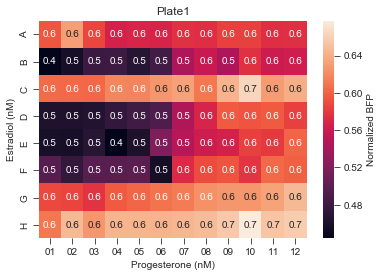

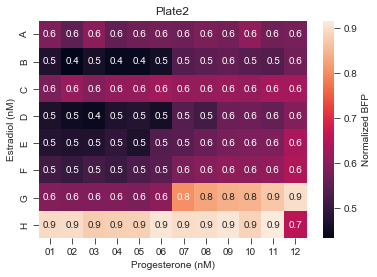

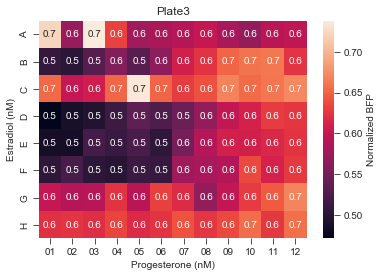

In [12]:
for plate in strains:
    sns.heatmap(BFPnorm[plate].med.astype(float),annot=True,fmt='.1f',cbar_kws={'label': 'Normalized BFP'})
    plt.title(plate)
    plt.xlabel('Progesterone (nM)')
    plt.ylabel('Estradiol (nM)')

    dest = date + plate + 'BFPheatmap'
    plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
    plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)
    plt.show()
    plt.close()

## Work up histograms of the data in a 96 well plate format

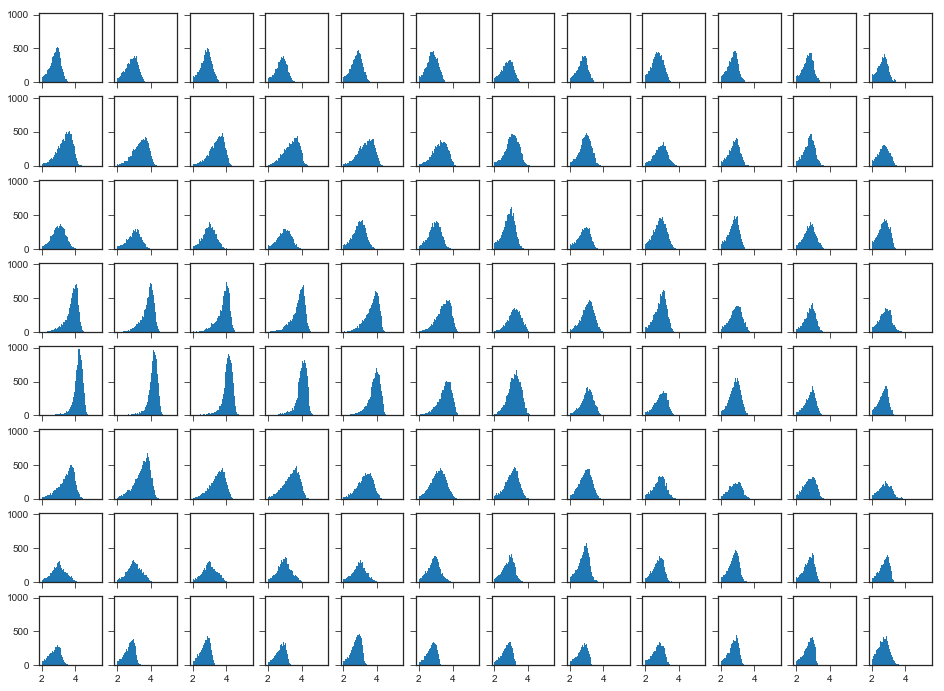

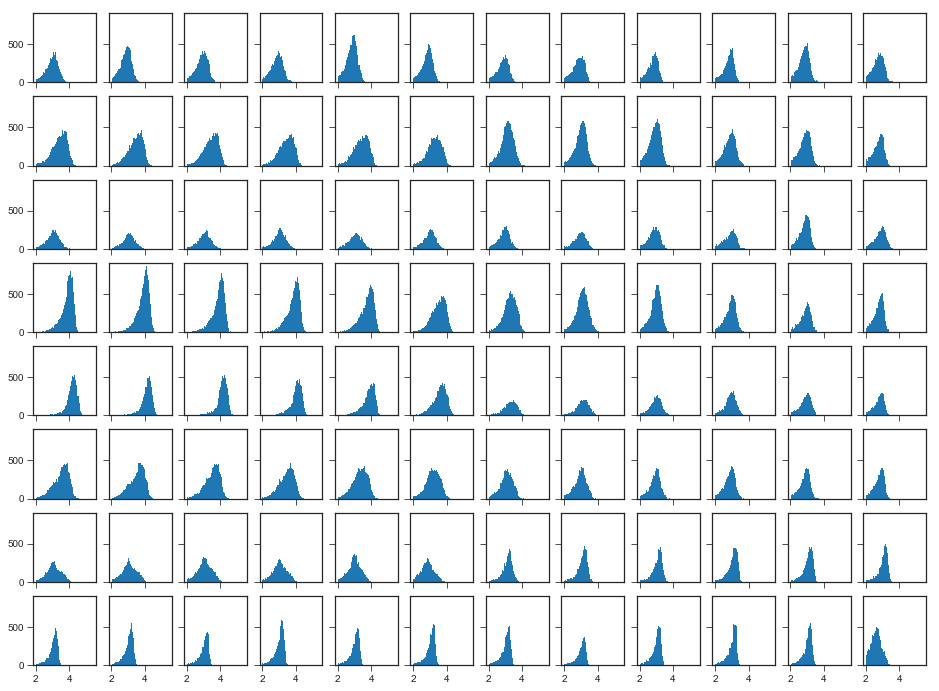

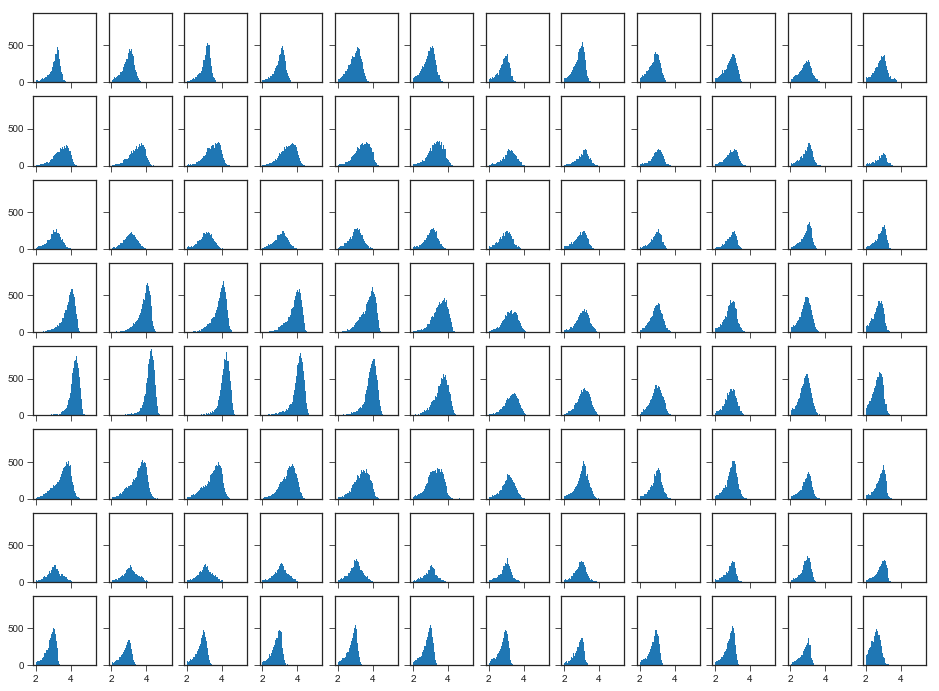

In [13]:
for plate in strains:
    FITCclean = pd.DataFrame(index = rows, columns = cols)
    logFITCclean = pd.DataFrame(index = rows, columns = cols)

    for row in rows:
        for col in cols:
            try:
                FITCclean.loc[row,col] = cleandata(allplates[plate].loc[row,col].data['FITC-A'].values,100)
                logFITCclean.loc[row,col] = np.log10(cleandata(allplates[plate].loc[row,col].data['FITC-A'].values,100))
            except:
                continue

    FITC_bincenter = pd.DataFrame(index = rows, columns = cols)
    FITC_histy = pd.DataFrame(index = rows, columns = cols)

    fig, ax = plt.subplots(8, 12,sharex = True, sharey = True, figsize=(16,12))

    for i in range(8):
        for j in range(12):
            try:
                FITC_histy.iloc[i,j],FITC_bincenter.iloc[i,j] = ax[i,j].hist(logFITCclean.iloc[i,j][~np.isnan(logFITCclean.iloc[i,j])],50)
            except:
                continue

    dest = date + plate + 'fullhist'
    plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
    plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)
    plt.show()
    plt.close()

# Process the data into arrays; calculate means and standard deviation

In [10]:
MATstrs = ['pAGA1','pFIG1','pAGA1-key_m12','pFIG1-key_m12','pREV1','pRNR2','pRET2','pRPL18B']

In [11]:
#Average across the triplicate plates

FITCavg = pd.DataFrame(index = MATstrs, columns = cols)
BFPavg = pd.DataFrame(index = MATstrs, columns = cols)

FITCstd = pd.DataFrame(index = MATstrs, columns = cols)
BFPstd = pd.DataFrame(index = MATstrs, columns = cols)


for j, r in enumerate(MATstrs[0:8]):
    for i, c in enumerate(cols):
        FITCavg.set_value(r, c, np.mean([FITCnorm['Plate1'].med.iloc[j,i],FITCnorm['Plate2'].med.iloc[j,i],FITCnorm['Plate3'].med.iloc[j,i]]))
        FITCstd.set_value(r, c, np.std([FITCnorm['Plate1'].med.iloc[j,i],FITCnorm['Plate2'].med.iloc[j,i],FITCnorm['Plate3'].med.iloc[j,i]]))

        BFPavg.set_value(r, c, np.mean([BFPnorm['Plate1'].med.iloc[j,i],BFPnorm['Plate2'].med.iloc[j,i],BFPnorm['Plate3'].med.iloc[j,i]]))
        BFPstd.set_value(r, c, np.std([BFPnorm['Plate1'].med.iloc[j,i],BFPnorm['Plate2'].med.iloc[j,i],BFPnorm['Plate3'].med.iloc[j,i]]))

for j, r in enumerate(MATstrs[8:10]):
    for i, c in enumerate(cols):
        FITCavg.set_value(r, c, np.mean([FITCnorm['Plate4'].med.iloc[3*j,i],FITCnorm['Plate4'].med.iloc[3*j+1,i],FITCnorm['Plate4'].med.iloc[3*j+2,i]]))
        FITCstd.set_value(r, c, np.std([FITCnorm['Plate4'].med.iloc[3*j,i],FITCnorm['Plate4'].med.iloc[3*j+1,i],FITCnorm['Plate4'].med.iloc[3*j+2,i]]))

        BFPavg.set_value(r, c, np.mean([BFPnorm['Plate4'].med.iloc[3*j,i],BFPnorm['Plate4'].med.iloc[3*j+1,i],BFPnorm['Plate4'].med.iloc[3*j+2,i]]))
        BFPstd.set_value(r, c, np.std([BFPnorm['Plate4'].med.iloc[3*j,i],BFPnorm['Plate4'].med.iloc[3*j+1,i],BFPnorm['Plate4'].med.iloc[3*j+2,i]]))
  

/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if sys.path[0] == '':
/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  del sys.path[0]
/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:15: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  from ipykernel import kernelapp as app
/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  app.launch_new_instance()


In [12]:
#Read data from Ste12FB experiment

FITCavg_0730 = pd.read_pickle('20180730STE12FITCavg.pkl')
FITCstd_0730 = pd.read_pickle('20180730STE12FITCstd.pkl')

IOError: [Errno 2] No such file or directory: '20180730STE12FITCavg.pkl'

# Fit hill function to data

In [15]:
## Fit a standard hill function to the data
from scipy.optimize import curve_fit

def hillfn(a, Fmin, Fmax, n, Cm):
    return Fmin + (Fmax-Fmin) * (a**n / (Cm**n + a**n))

In [16]:
popt = pd.DataFrame(index = MATstrs, columns = ['Fmin', 'Fmax','n','Cm'])
pcov = pd.DataFrame(index = MATstrs, columns = ['Fmin', 'Fmax','n','Cm'])

Fmin = FITCavg.iloc[:,11].astype(float)
Fmax = FITCavg.iloc[:,0].astype(float)
a = np.asarray(Aconc)

for s in MATstrs:
    popt.at[s,:], cov = curve_fit(hillfn, a, FITCavg.loc[s].astype(float), p0 = [Fmin.loc[s], Fmax.loc[s], 1, 12])

/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in power
  after removing the cwd from sys.path.
/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in divide
  after removing the cwd from sys.path.
/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


In [17]:
#display fit
popt

,Fmin,Fmax,n,Cm
pAGA1,0.115283,0.149456,0.552407,0.197176
pFIG1,0.157091,0.563685,1.89688,1.59364
pAGA1-key_m12,0.122095,0.198622,0.827116,0.349712
pFIG1-key_m12,0.175631,1.24812,1.74859,2.87933
pREV1,0.144035,2.7285,1.30204,6.07029
pRNR2,0.136014,0.983383,1.42594,5.7439
pRET2,0.122917,0.185135,1.02608,2.09279
pRPL18B,0.116954,0.121112,5.16873e-07,5.32129


# Plot the data

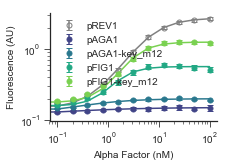

In [45]:
# Compare against pREV1
Yellows = sns.color_palette('viridis_r',4)

fig, ax = plt.subplots(figsize=(3,2))

ax.errorbar(Aconc[::-1],FITCavg.loc['pREV1',::-1],yerr=FITCstd.loc['pREV1',::-1],capsize=3,fmt ='o', ms=5,mew=1,mec='grey',mfc = 'none', color = 'grey', label = 'pREV1')
ax.plot(Aconc, hillfn(a, *popt.loc['pREV1']), color = 'grey')

ax.errorbar(Aconc[::-1],FITCavg.loc['pAGA1',::-1],yerr=FITCstd.loc['pAGA1',::-1],capsize=3,fmt ='o', ms=5, color = Yellows[3], label = 'pAGA1')
ax.plot(Aconc, hillfn(a, *popt.loc['pAGA1']), color = Yellows[3])

ax.errorbar(Aconc[::-1],FITCavg.loc['pAGA1-key_m12',::-1],yerr=FITCstd.loc['pAGA1-key_m12',::-1],capsize=3,fmt ='o', ms=5, color = Yellows[2], label = 'pAGA1-key_m12')
ax.plot(Aconc, hillfn(a, *popt.loc['pAGA1-key_m12']), color = Yellows[2])

ax.errorbar(Aconc[::-1],FITCavg.loc['pFIG1',::-1],yerr=FITCstd.loc['pFIG1',::-1],capsize=3,fmt = 'o', ms=5, color = Yellows[1], label = 'pFIG1')
ax.plot(Aconc, hillfn(a, *popt.loc['pFIG1']), color = Yellows[1])

ax.errorbar(Aconc[::-1],FITCavg.loc['pFIG1-key_m12',::-1],yerr=FITCstd.loc['pFIG1-key_m12',::-1],capsize=3,fmt = 'o', ms=5, color = Yellows[0], label = 'pFIG1-key_m12')
ax.plot(Aconc, hillfn(a, *popt.loc['pFIG1-key_m12']), color = Yellows[0])

ax.set_ylabel('Fluorescence (AU)')
ax.set_yscale('log')

ax.set_xlabel('Alpha Factor (nM)')
ax.set_xscale('log')
#ax[i].set_xticks(Aconcind)
#ax[i].set_xticklabels(Aconc[::-1],rotation = 60)
ax.legend()

#ax1.set_xticks(Pconcind)
#ax2.set_yscale('log',basey=2)
sns.despine()
dest = date + 'fitSTE12tuning_comparisonYFP'
plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)
plt.show()
plt.close()

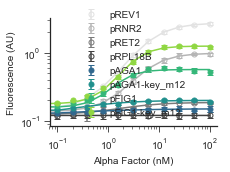

In [43]:
#Compare everything

Yellows = sns.color_palette('viridis_r',5)
Greys = sns.color_palette('Greys',4)

fig, ax = plt.subplots(figsize=(3,2))

ax.errorbar(Aconc[::-1],FITCavg.loc['pREV1',::-1],yerr=FITCstd.loc['pREV1',::-1],capsize=3,fmt ='o', ms=5,mew=1,mec=Greys[0],mfc = 'none', color = Greys[0], label = 'pREV1')
ax.plot(Aconc, hillfn(a, *popt.loc['pREV1']), color = Greys[0])

ax.errorbar(Aconc[::-1],FITCavg.loc['pRNR2',::-1],yerr=FITCstd.loc['pRNR2',::-1],capsize=3,fmt ='o', ms=5,mew=1,mec=Greys[1],mfc = 'none', color = Greys[1], label = 'pRNR2')
ax.plot(Aconc, hillfn(a, *popt.loc['pRNR2']), color = Greys[1])

ax.errorbar(Aconc[::-1],FITCavg.loc['pRET2',::-1],yerr=FITCstd.loc['pRET2',::-1],capsize=3,fmt ='o', ms=5,mew=1,mec=Greys[2],mfc = 'none', color = Greys[2], label = 'pRET2')
ax.plot(Aconc, hillfn(a, *popt.loc['pRET2']), color = Greys[2])

ax.errorbar(Aconc[::-1],FITCavg.loc['pRPL18B',::-1],yerr=FITCstd.loc['pRPL18B',::-1],capsize=3,fmt ='o', ms=5,mew=1,mec=Greys[3],mfc = 'none', color = Greys[3], label = 'pRPL18B')
ax.plot(Aconc, hillfn(a, *popt.loc['pRPL18B']), color = Greys[3])

ax.errorbar(Aconc[::-1],FITCavg.loc['pAGA1',::-1],yerr=FITCstd.loc['pAGA1',::-1],capsize=3,fmt ='o', ms=5, color = Yellows[3], label = 'pAGA1')
ax.plot(Aconc, hillfn(a, *popt.loc['pAGA1']), color = Yellows[3])

ax.errorbar(Aconc[::-1],FITCavg.loc['pAGA1-key_m12',::-1],yerr=FITCstd.loc['pAGA1-key_m12',::-1],capsize=3,fmt ='o', ms=5, color = Yellows[2], label = 'pAGA1-key_m12')
ax.plot(Aconc, hillfn(a, *popt.loc['pAGA1-key_m12']), color = Yellows[2])

ax.errorbar(Aconc[::-1],FITCavg.loc['pFIG1',::-1],yerr=FITCstd.loc['pFIG1',::-1],capsize=3,fmt = 'o', ms=5, color = Yellows[1], label = 'pFIG1')
ax.plot(Aconc, hillfn(a, *popt.loc['pFIG1']), color = Yellows[1])

ax.errorbar(Aconc[::-1],FITCavg.loc['pFIG1-key_m12',::-1],yerr=FITCstd.loc['pFIG1-key_m12',::-1],capsize=3,fmt = 'o', ms=5, color = Yellows[0], label = 'pFIG1-key_m12')
ax.plot(Aconc, hillfn(a, *popt.loc['pFIG1-key_m12']), color = Yellows[0])

ax.set_ylabel('Fluorescence (AU)')
ax.set_yscale('log')

ax.set_xlabel('Alpha Factor (nM)')
ax.set_xscale('log')
#ax[i].set_xticks(Aconcind)
#ax[i].set_xticklabels(Aconc[::-1],rotation = 60)
ax.legend()

#ax1.set_xticks(Pconcind)
#ax2.set_yscale('log',basey=2)
sns.despine()
dest = date + 'fitSTE12tuning_comparisonYFP_viridis'
plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)
plt.show()
plt.close()